# Introduction To Sentiment Analysis
Sentiment analysis refers to analyzing an opinion or feelings about something using data like text or images, regarding almost anything. Sentiment analysis helps companies in their decision-making process. For instance, if public sentiment towards a product is not so good, a company may try to modify the product or stop the production altogether in order to avoid any losses.

There are many sources of public sentiment e.g. public interviews, opinion polls, surveys, etc. However, with more and more people joining social media platforms, websites like Facebook and Twitter can be parsed for public sentiment.


# Problem Definition
Given tweets about six US airlines, the task is to predict whether a tweet contains positive, negative, or neutral sentiment about the airline. This is a typical supervised learning task where given a text string, we have to categorize the text string into predefined categories.

# Solution
To solve this problem, we will follow the typical machine learning pipeline. We will first import the required libraries and the dataset. We will then do exploratory data analysis to see if we can find any trends in the dataset. Next, we will perform text preprocessing to convert textual data to numeric data that can be used by a machine learning algorithm. Finally, we will use machine learning algorithms to train and test our sentiment analysis models.

In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
airline_tweets = pd.read_csv(r'D:\Tweets.csv')
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Let's explore the dataset a bit to see if we can find any trends. But before that, we will change the default plot size to have a better view of the plots. 

In [3]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

6.4
4.8


# Exploration Of Data
## Let's first see the number of tweets for each airline. We will plot a pie chart for that:

<Axes: ylabel='airline'>

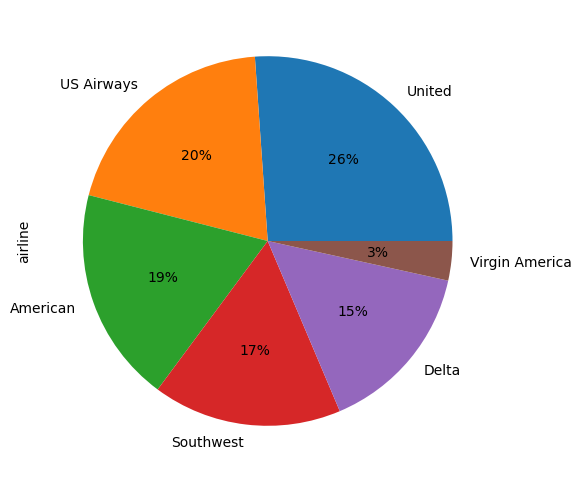

In [9]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

Let's now see the distribution of sentiments across all the tweets. 

<Axes: ylabel='airline_sentiment'>

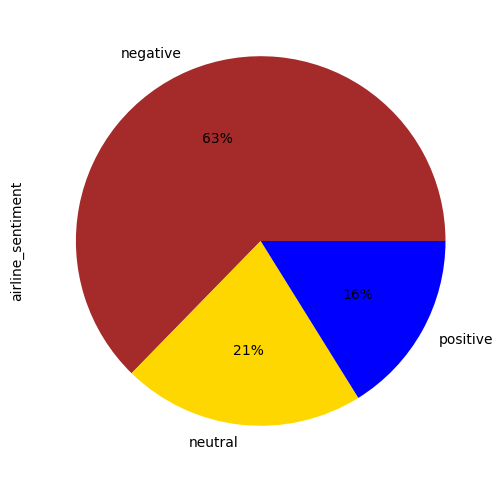

In [11]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["brown", "gold", "blue"])

<Axes: xlabel='airline'>

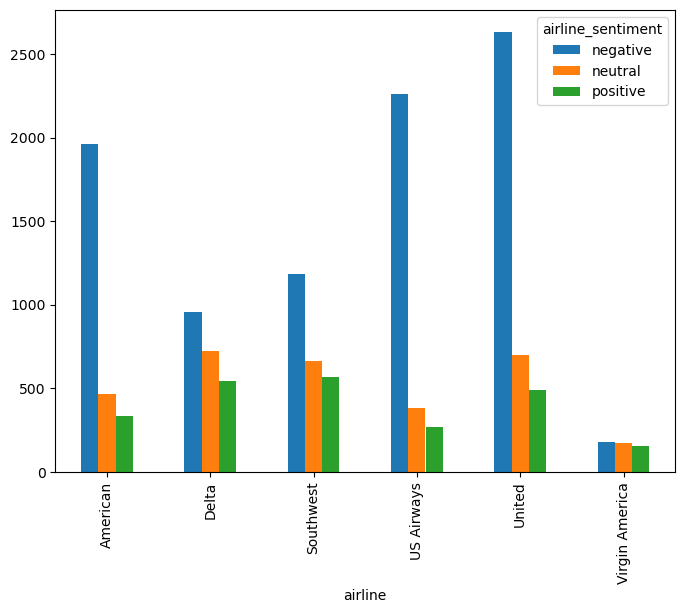

In [14]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

It is evident from the output that for almost all the airlines, the majority of the tweets are negative, followed by neutral and positive tweets. Virgin America is probably the only airline where the ratio of the three sentiments is somewhat similar.

Finally, let's use the Seaborn library to view the average confidence level for the tweets belonging to three sentiment categories. 

<Axes: xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

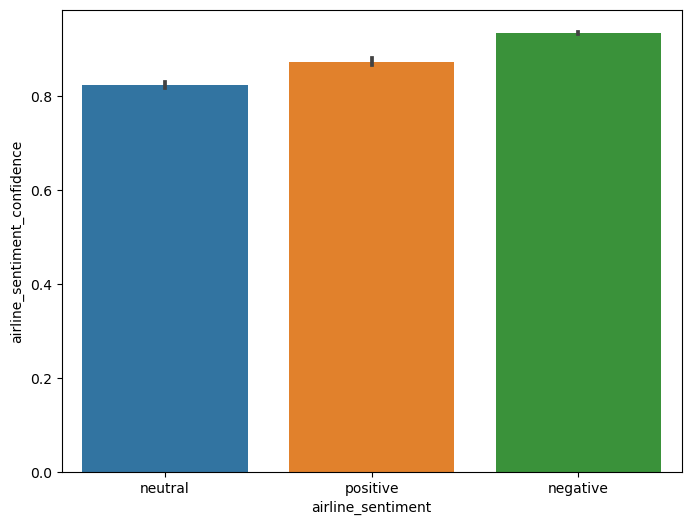

In [15]:
import seaborn as sns

sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)


From the output, you can see that the confidence level for negative tweets is higher compared to positive and neutral tweets.

# Data Cleaning
Tweets contain many slang words and punctuation marks. We need to clean our tweets before they can be used for training the machine learning model. However, before cleaning the tweets, let's divide our dataset into feature and label sets.

Our feature set will consist of tweets only. If we look at our dataset, the 11th column contains the tweet text. Note that the index of the column will be 10 since pandas columns follow zero-based indexing scheme where the first column is called 0th column. Our label set will consist of the sentiment of the tweet that we have to predict. The sentiment of the tweet is in the second column (index 1). To create a feature and a label set, we can use the iloc method off the pandas data frame.




In [20]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values


Once we divide the data into features and training set, we can preprocess data in order to clean it. 

In [19]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)


# TF-IDF
In the bag of words approach, each word has the same weight. The idea behind the TF-IDF approach is that the words that occur less in all the documents and more in individual document contribute more towards classification.

## TF-IDF is a combination of two terms. Term frequency and Inverse Document frequency.     They can be calculated as:

TF  = (Frequency of a word in the document) / (Total words in the document)

IDF = Log((Total number of docs) / (Number of docs containing the word))

## TF-IDF using the Scikit-Learn Library
Luckily for us, Python's Scikit-Learn library contains the TfidfVectorizer class that can be used to convert text features into TF-IDF feature vectors. The following script performs this:

In [20]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()


In the code above, we define that the max_features should be 2500, which means that it only uses the 2500 most frequently occurring words to create a bag of words feature vector. Words that occur less frequently are not very useful for classification.

Similarly, max_df specifies that only use those words that occur in a maximum of 80% of the documents. Words that occur in all documents are too common and are not very useful for classification. Similarly, min-df is set to 7 which shows that include words that occur in at least 7 documents.


# Dividing Data into Training and Test Sets
In the previous section, we converted the data into the numeric form. As the last step before we train our algorithms, we need to divide our data into training and testing sets. The training set will be used to train the algorithm while the test set will be used to evaluate the performance of the machine learning model.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)


In [22]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [23]:
predictions = text_classifier.predict(X_test)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print('accuracy score',accuracy_score(y_test, predictions))


[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
accuracy score 0.7599043715846995
